In [33]:
%matplotlib inline

import pandas
import numpy
import sklearn
from sklearn import metrics, datasets, model_selection

import sys
sys.path.insert(0, 'build/lib.linux-x86_64-3.6/')
import naivebayes
import embayesc

In [34]:
def prob_scipy(x, mean, std):
    return scipy.stats.norm.pdf(x, mean, std)

def prob_ref(x, mean, std):
    exponent = numpy.exp(- ((x - mean)**2 / (2 * std**2)))
    return (exponent / (numpy.sqrt(2 * numpy.pi) * std))

def logprob_ref(x, mean, std):
    return numpy.log2(prob_ref(x, mean, std))

## Approximate logarithmic prob

/usr/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


const float a = -0.7213475204444817;
const float b = -3.615717560684884e-16;
const float c = -1.3257480647361608;


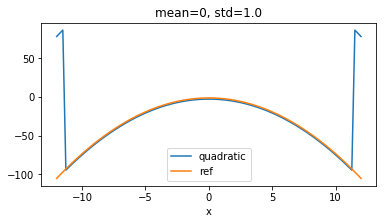

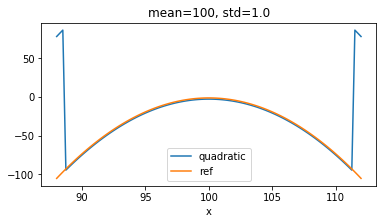

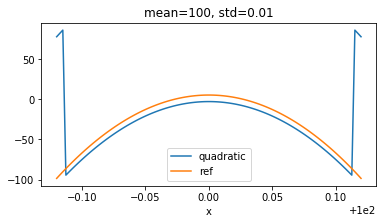

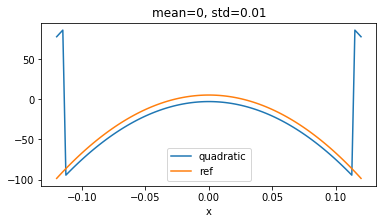

In [36]:
def quadratic(x, a, b, c):
    return a*(x**2) + b*x + c

sigma_fit = 10 
fitx = numpy.linspace(-sigma_fit, sigma_fit, 30)
fity = logprob_ref(fitx, 0.0, 1.0)
p0 = [0, 0, 0]
pnames = ['a', 'b', 'c']
popt_quadratic, pcov = curve_fit(quadratic, fitx, fity, p0=p0)

def c_constants(kw, ctype='const float'):
    v = ("{} {} = {};".format(ctype, k, v) for k,v in kw.items())
    return '\n'.join(v)

vals = dict(zip(pnames, popt_quadratic))
print(c_constants(vals))

def p_q(x, mean, std):
    xm = (x - mean) / (std)
    p = quadratic(xm, *popt_quadratic) - numpy.log2(std)
    return p
    
def prob_loglin_quadratic(x, mean, std):
    log2std = numpy.log2(std)
    if numpy.isscalar(x):
        x = [x]
    v = [ embayesc.logpdf(xx, mean, std, log2std) for xx in x ]
    return numpy.array(v)

sigma = 12
means, stds = ((0, 100, 100, 0), (1.0, 1.0, 0.01, 0.01))
for mean, std in zip(means, stds):
    start = mean-(sigma*std)
    points = numpy.linspace(start, mean+(sigma*std), 100)

    ref = logprob_ref(points, mean, std)
    fit = prob_loglin_quadratic(points, mean, std) - 0.5
    
    df = pandas.DataFrame({
        'x': points,
        'ref': ref,
        'quadratic': fit,
    }).plot(x='x', figsize=(6,3), title='mean={}, std={}'.format(mean, std))


In [31]:
class GaussianNB(object):
    def __init__(self):
        pass

    def fit(self, X, y):
        separated = [[x for x, t in zip(X, y) if t == c] for c in np.unique(y)]
        self.model = np.array([np.c_[np.mean(i, axis=0), np.std(i, axis=0)] for i in separated])
        return self

    def _prob(self, x, mean, std):
        return np.log(prob_ref(x, mean, std))

    def predict_log_proba(self, X):            
        def class_probability(summaries, x):
            probs = [self._prob(i, *s) for s, i in zip(summaries, x)]
            ss = sum(probs)
            sss = numpy.sum(probs)
            return sss
        return [[ class_probability(s, x) for s in self.model] for x in X]

    def predict(self, X):
        n_classes, n_features, _ = self.model.shape
        model = list(numpy.ravel(self.model))
        self.classifier = embayesc.Classifier(model, n_classes, n_features)

        cp = [ self.classifier.predict(x) for x in X ]
        #pp = np.argmax(self.predict_log_proba(X), axis=1)
        return cp

    def score(self, X, y):
        return sum(self.predict(X) == y) / len(y)
    

In [32]:
# Data
data = datasets.load_breast_cancer()
label_names = data['target_names']
labels = data['target']
feature_names = data['feature_names']
features = data['data']

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

S = model_selection.train_test_split(features, labels, test_size=0.33, random_state=42)
train, test, train_labels, test_labels = S
classifiers = [
    GaussianNB(),
    #GaussianFast(),
    #GaussianCos(),
    #GaussianFixed(),
    #GaussianLinear(),
]
acc = []
for estimator in classifiers:
    # Train
    s  = StandardScaler()
    gnb = estimator
    train = s.fit_transform(train)
    model = gnb.fit(train, train_labels)
    #print(model.model.shape, train.shape)
    #print(model.model)
    # Tests
    test = s.transform(test)
    preds = gnb.predict(test)
    acc.append(metrics.accuracy_score(test_labels, preds))

print(acc)

[0.9042553191489362]
